In [2]:
# Lets import some libraries
import os

import torch
#import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
from torch.utils.data import Dataset , DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import time

%matplotlib inline

In [59]:
inpDir = 'D:\DNN\input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'D:\DNN\images' # location of the images
modelDir = '../models'
altName = '?????'
modelSubDir = 'pytorch_fashion'

RANDOM_STATE = 24

torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 50 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
NUM_BATCHES = 6 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'brg' # 

plt.cm.Spectral

plt.rcParams.update(params)

In [18]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename)
test_df = pd.read_csv(test_filename)
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
class_labels= {0 : 'T-shirt/top',
         1  : 'Trouser',
         2  : 'Pullover',
         3 : 'Dress',
         4 : 'Coat',
         5 : 'Sandal',
         6 : 'Shirt',
         7 : 'Sneaker',
         8 : 'Bag',
         9 : 'Ankle boot'}

In [21]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


In [22]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,16)
        self.layer2 = nn.Linear(16, 4)
        
    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = F.softmax(self.layer2(x), dim = 1)
        return x

net = Model(train_df.shape[1]).to(device) # Create model on GPU
print (net)

Model(
  (layer1): Linear(in_features=785, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=4, bias=True)
)


In [23]:

class FashionDs(Dataset):

    def __init__(self, dataframe: pd.DataFrame, device: str = device) :

        self.device = device
        self.df = dataframe
        self.labels = self.df['label'].to_numpy()
        X = self.df.drop('label', axis=1).to_numpy()
        self.features = X/255.

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        features = self.features[index]
        label = self.labels[index]

        features = torch.tensor(features, dtype=torch.float32, device=self.device)

        label = torch.tensor(label, dtype=torch.int64, device=self.device)

        return features, label


In [24]:

train_ds = FashionDs(train_df)
test_ds = FashionDs(test_df)


In [25]:


train_loader = DataLoader(train_ds,
                          batch_size=32,
                          shuffle=True)

test_loader = DataLoader(test_ds,
                          batch_size=32,
                          shuffle=True)



In [26]:
images, targets = next(iter(train_loader))

images = images.cpu().numpy()
targets = targets.cpu().numpy()
targets

array([0, 2, 0, 8, 4, 0, 7, 4, 8, 8, 5, 8, 5, 2, 5, 4, 6, 6, 5, 2, 0, 2,
       1, 0, 2, 1, 7, 1, 5, 8, 7, 3], dtype=int64)

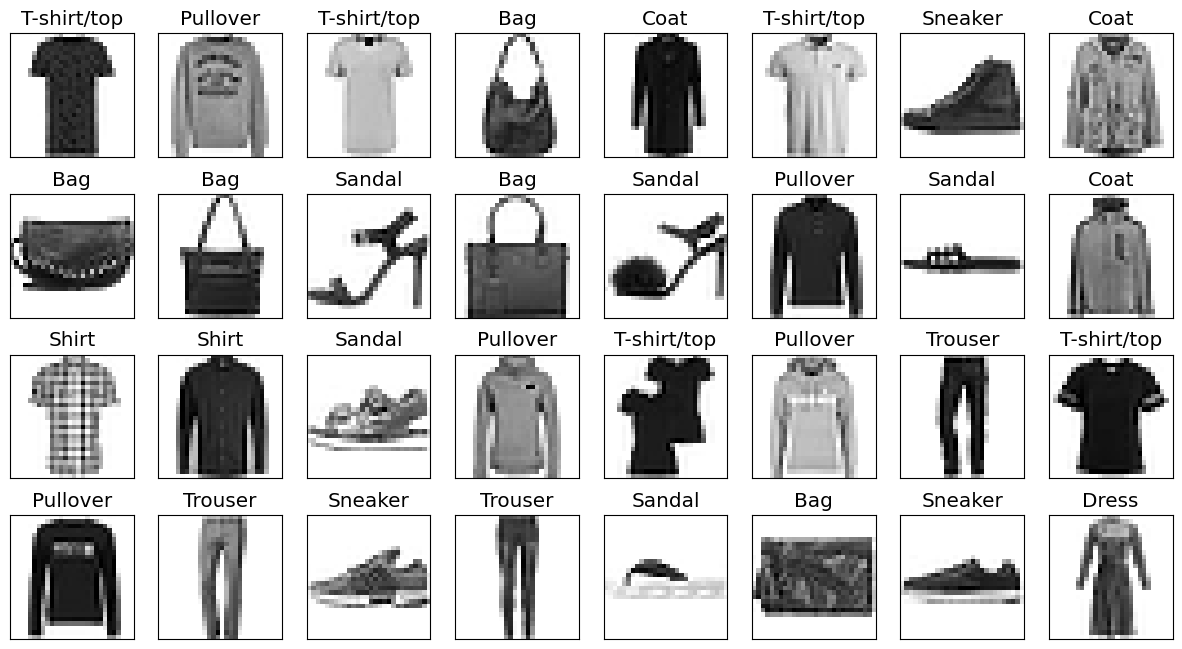

In [13]:
plt.figure(figsize=(15,8))

for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(images[i].reshape(28, 28), cmap=plt.cm.binary)

    plt.xticks([])
    plt.yticks([])

    plt.grid(False)
    plt.title(class_labels[targets[i]])

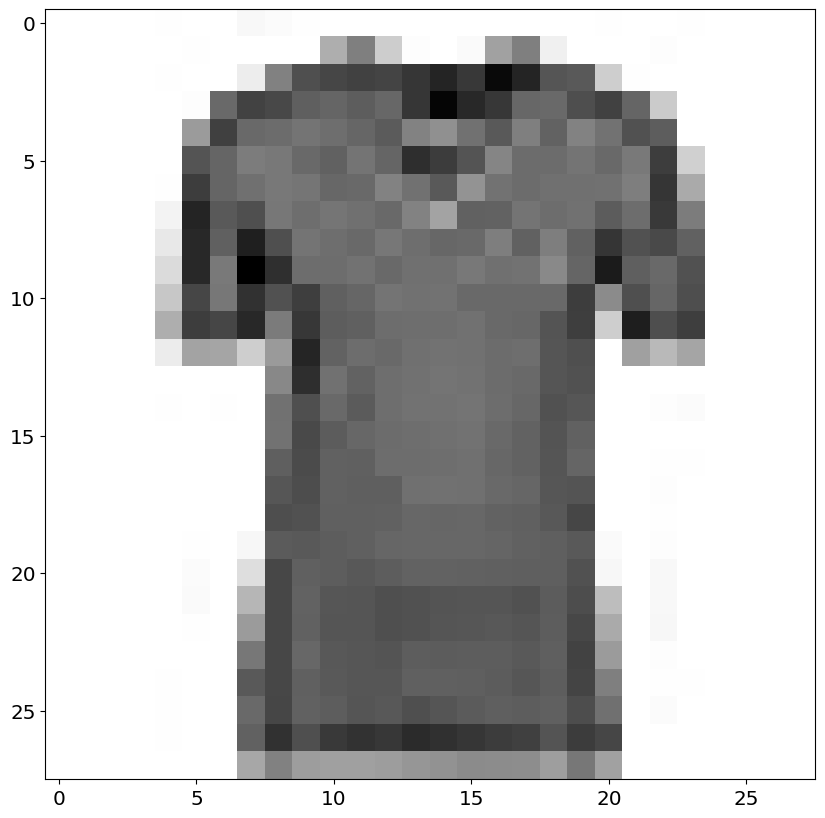

In [30]:
images, targets = next(iter(train_loader))

images = images.cpu().numpy()
plt.imshow(images[0].reshape(28,28),cmap=plt.cm.binary)

In [32]:
images.shape

(32, 784)

In [34]:
input_shape = train_df.shape[-1] -1
input_shape

784

In [37]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,128)
        self.activ1 = nn.Tanh()
        self.layer2 = nn.Linear(128, 32)
        self.activ2 = nn.Tanh()
        self.layer3 = nn.Linear(32, 10)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = self.layer1(x)
        x = self.activ1(x)
        x = self.layer2(x)
        x = self.activ2(x)
        x = self.layer3(x)
        return self.softmax(x)

net = Model(input_dim=input_shape).to(device) # Create model on GPU
print (net)

Model(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (activ1): Tanh()
  (layer2): Linear(in_features=128, out_features=32, bias=True)
  (activ2): Tanh()
  (layer3): Linear(in_features=32, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [60]:
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss , tloss = [] , []
acc , tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(net.parameters(), lr = ALPHA , weight_decay=1e-5)


for epoch in range(EPOCHS):
    train_loss = 0.0
    train_acc = 0.0

    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        for data in test_loader:
            
            inputs, labels = data
            
            outputs = net(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)
    
    if epoch%5 == 0:
        print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')
    
   

At epoch 0 | Loss - train:0.1704, test:0.3347 | Acc - train:0.9375, test:0.8852
At epoch 5 | Loss - train:0.1615, test:0.3393 | Acc - train:0.9402, test:0.8887
At epoch 10 | Loss - train:0.1551, test:0.3672 | Acc - train:0.9429, test:0.8853
At epoch 15 | Loss - train:0.1524, test:0.3641 | Acc - train:0.9431, test:0.8903
At epoch 20 | Loss - train:0.1388, test:0.3621 | Acc - train:0.9494, test:0.8919
At epoch 25 | Loss - train:0.1342, test:0.3935 | Acc - train:0.9507, test:0.8856
At epoch 30 | Loss - train:0.1297, test:0.3716 | Acc - train:0.9523, test:0.8865
At epoch 35 | Loss - train:0.1222, test:0.4255 | Acc - train:0.9550, test:0.8777
At epoch 40 | Loss - train:0.1204, test:0.4020 | Acc - train:0.9566, test:0.8857
At epoch 45 | Loss - train:0.1187, test:0.4153 | Acc - train:0.9566, test:0.8824


In [66]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,0.170423,0.334699,0.937450,0.8852
1,1,0.168967,0.351680,0.938033,0.8876
2,2,0.169659,0.331834,0.937050,0.8943
3,3,0.164454,0.327980,0.939717,0.8913
4,4,0.163666,0.343827,0.939350,0.8877


In [67]:
y_train = []
y_pred = []
for i, data in enumerate(train_loader):
    
    inputs, labels = data
    
    outputs = net(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_train.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [69]:
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()


def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

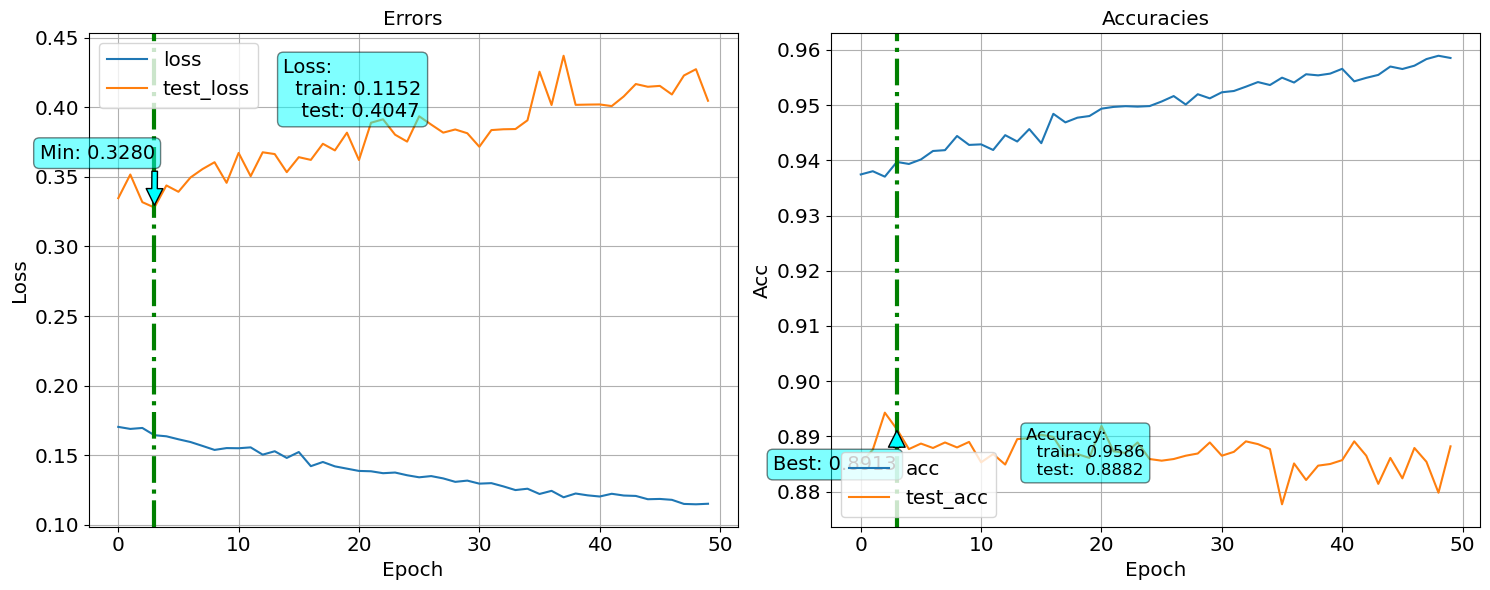

In [70]:
fn_plot_torch_hist(loss_df)


In [71]:
print(classification_report(y_train,y_pred))


              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6000
           1       1.00      1.00      1.00      6000
           2       0.92      0.94      0.93      6000
           3       0.95      0.99      0.97      6000
           4       0.92      0.92      0.92      6000
           5       1.00      1.00      1.00      6000
           6       0.93      0.88      0.91      6000
           7       0.99      1.00      1.00      6000
           8       1.00      1.00      1.00      6000
           9       1.00      0.99      1.00      6000

    accuracy                           0.97     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.97      0.97      0.97     60000



In [72]:
X = train_df.drop('label',axis=1).to_numpy()/255.
y_true = train_df['label'].to_numpy()
X = torch.tensor(X , dtype= torch.float32).to(device)
X

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [73]:
with torch.inference_mode():
    preds =net(X)
    y_pred = preds.argmax(dim = 1)
    y_pred = y_pred.cpu().numpy()
y_pred.shape

(60000,)

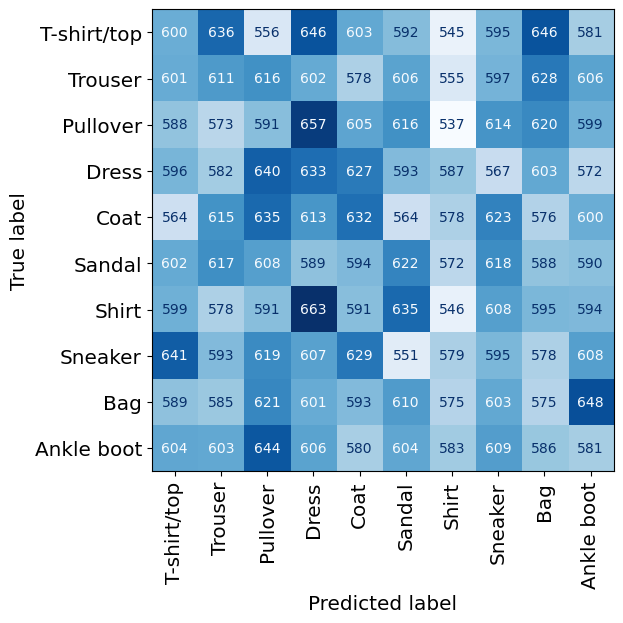

In [74]:
fn_plot_confusion_matrix(y_train ,  y_pred , class_labels)

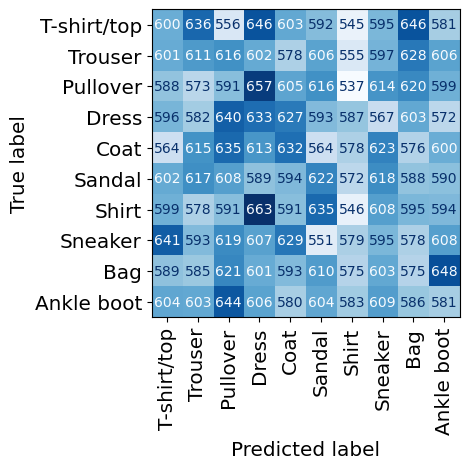

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


cm  = confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();

In [76]:
y_test = []
y_pred = []
for i, data in enumerate(test_loader):
    
    inputs, labels = data
    
    outputs = net(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_test.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())